In [1]:
import os, glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from utils import featre_to_tick, get_colors_dict
import argparse
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
# keep only columns that are related to mutations
gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")
sel_cols = [col for col in gene_expr_all.columns if "_cnv" in col]
gene_expr_all = gene_expr_all[['type', 'case_id', 'slide_id'] + sel_cols]

col_rename_dict = {col: col.split("_")[0] for col in sel_cols}
gene_expr_all = gene_expr_all.rename(columns=col_rename_dict)

C:\Users\u2070124\AppData\Local\Temp\ipykernel_27724\873066277.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_expr_all = pd.read_csv("gene/data/PORPOISE_data_matched.csv")


In [3]:
selected_feats = [
"mit_wsi_count",
"mit_hotspot_count",
"mit_nodeDegrees_mean",
"mit_nodeDegrees_max",
"mit_nodeDegrees_std",
"mit_clusterCoff_mean",
"mit_clusterCoff_std",
"mit_clusterCoff_perc10",
"mit_clusterCoff_perc80",
"mit_cenDegree_mean",
"mit_cenDegree_std",
"mit_cenCloseness_max",
"mit_cenEigen_mean",
"mit_cenEigen_max",
"mit_cenEigen_std",
"mit_cenHarmonic_mean",
"mit_cenHarmonic_std",
]
mitosis_feats = pd.read_csv('D:/tcga/tcga_mitosis_ClusterByCancer.csv') # pd.read_csv('/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv')
mitosis_feats = mitosis_feats[["bcr_patient_barcode", "type"]+selected_feats]
mitosis_feats.columns = [featre_to_tick(col) if col not in ["bcr_patient_barcode", "type"] else col for col in mitosis_feats.columns]
mitosis_feats["type"] = mitosis_feats["type"].replace(["COAD", "READ"], "COADREAD")

In [4]:
gene_expr_all["type"].unique()

array(['LUSC', 'STAD', 'SKCM', 'BRCA', 'LUAD', 'COADREAD', 'HNSC', 'PAAD',
       'UCEC', 'GBM', 'LGG', 'KIRC', 'BLCA', 'LIHC', 'KIRP'], dtype=object)

In [4]:
cancer_type = "BRCA"
mitosis_feats_cancer = mitosis_feats[mitosis_feats["type"]==cancer_type]
gene_exp_cancer = gene_expr_all[gene_expr_all["type"]==cancer_type]


# drop missing mutations
gene_exp_cancer = gene_exp_cancer.dropna(axis=1, how="all")

# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mitosis_feats_cancer['bcr_patient_barcode']).intersection(set(gene_exp_cancer['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats_cancer[mitosis_feats_cancer['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_exp_cancer[gene_exp_cancer['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

## Sort the dataframes based on 'case_name'
df1_common = df1_common.sort_values('bcr_patient_barcode')
df2_common = df2_common.sort_values('case_id')

X = df1_common.drop(columns=["bcr_patient_barcode", "type"]).reset_index(drop=True)
Y = df2_common.drop(columns=['case_id', 'type', 'slide_id']).reset_index(drop=True)

X = X[X.std(axis=0).index[X.std(axis=0)!=0]]


In [5]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

def calculate_corr_matrix(df1, df2, method='spearman', pvalue_correction="fdr_bh"):
    if method not in ['spearman', 'pearson']:
        raise ValueError("Method must be 'spearman' or 'pearson'")
    
    # Drop rows with NaN values in Y and align the indices
    non_nan_indices = ~df2.isna().any(axis=1)
    df1 = df1.loc[non_nan_indices]
    df2 = df2.loc[non_nan_indices]

    # scaling the data
    scaler = MinMaxScaler()
    df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns, index=df1.index)
    df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)

    corr_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    pvalue_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float32)
    for row in df1.columns:
        for col in df2.columns:
            if method == 'spearman':
                corr, pvalue = stats.spearmanr(df1[row], df2[col])
            elif method == 'pearson':
                corr, pvalue = stats.pearsonr(df1[row], df2[col])
            corr_matrix.at[row, col] = np.float32(corr)
            pvalue_matrix.at[row, col] = np.float32(pvalue)
    # correcting pvalues for the number of genes
    if pvalue_correction is not None:
        # Flatten the DataFrame to a 1D array
        pvals = pvalue_matrix.values.flatten()
        # Apply the correction
        corrected_pvals = multipletests(pvals, alpha=0.05, method=pvalue_correction)[1]
        # Reshape the corrected p-values back to the original shape of pvalue_matrix
        corrected_pvals_matrix = corrected_pvals.reshape(pvalue_matrix.shape)
        # Replace the values in the original DataFrame
        pvalue_matrix.loc[:, :] = corrected_pvals_matrix

    return corr_matrix, pvalue_matrix

corr_matrix, pvalue_matrix = calculate_corr_matrix(X, Y)
# # drop duplicated mutations
# auc_matrix = auc_matrix.loc[~auc_matrix.index.duplicated(keep='first')]

C:\Users\u2070124\AppData\Local\Temp\ipykernel_27724\4128368190.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.97440440e-19 2.40220558e-26 8.09624297e-27 5.84791168e-26
 3.56899606e-26 2.26830410e-26 8.29044929e-03 1.88484046e-14
 5.11797824e-03 1.78656220e-09 5.77509641e-04 8.09403213e-03
 1.43366414e-14 5.36905859e-21 1.66726004e-15 5.40730928e-26
 9.47627525e-26]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pvalue_matrix.loc[:, :] = corrected_pvals_matrix
C:\Users\u2070124\AppData\Local\Temp\ipykernel_27724\4128368190.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.82727790e-20 3.70942831e-27 1.27599939e-27 7.16776220e-27
 4.74589572e-27 1.98396184e-27 4.67997538e-03 1.26774356e-15
 5.05069789e-03 2.17781638e-09 6.86791959e-04 5.21664045e-03
 1.08243327e-14 1.10249078e-21 6.0428

In [6]:
ref_corr = corr_matrix.T
ref_pvalue = pvalue_matrix.T

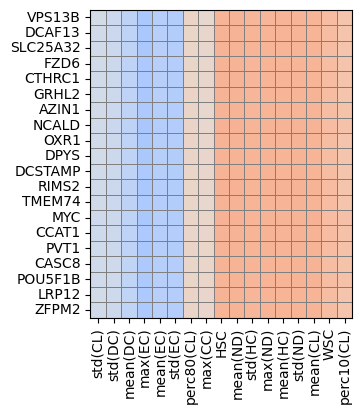

In [7]:
from scipy.cluster.hierarchy import linkage, leaves_list

auc_matrix = ref_corr.copy()
pval_matrix = ref_pvalue.copy()
if len(auc_matrix) > 20:
    aucs_sorted = auc_matrix.abs().max(axis=1).sort_values(ascending=False)
    max_ass = aucs_sorted.head(20).index
    auc_matrix = auc_matrix.loc[list(max_ass), :]
    pval_matrix = pval_matrix.loc[list(max_ass), :]

# Perform hierarchical clustering
row_linkage = linkage(auc_matrix, method='ward')
col_linkage = linkage(auc_matrix.T, method='ward')

# Get the order of rows and columns based on clustering
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the data matrix
auc_matrix_reordered = auc_matrix.iloc[:, col_order].iloc[row_order, :]
pval_matrix_reordered = pval_matrix.iloc[:, col_order].iloc[row_order, :]

# Plot the heatmap with reordered data and customization
plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(auc_matrix_reordered, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                      linewidths=0.5, linecolor='gray', square=True,
                      cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'})


for _, spine in heatmap.spines.items():
    spine.set_visible(True)

# # # Adjust colorbar label
# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('Scaled AUC', rotation=270, labelpad=15)
# plt.xticks(rotation=30, ha='right')
plt.show()

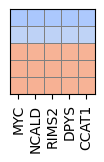

In [15]:
# Sort the DataFrame rows and columns alphabetically
# auc_matrix_sorted = auc_matrix.sort_index(axis=0)#.sort_index(axis=1)
# auc_matrix_sorted = auc_matrix_sorted[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)"]] # select only desired features

# auc_matrix_reordered = auc_matrix_reordered[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)"]] 
# pval_matrix_reordered = pval_matrix_reordered[["HSC", "mean(ND)", "mean(CL)", "mean(DC)", "max(EC)"]] 

auc_matrix_reordered = auc_matrix_reordered[["max(EC)", "mean(DC)", "mean(CL)", "mean(ND)", "HSC", ]] 
pval_matrix_reordered = pval_matrix_reordered[["max(EC)", "mean(DC)", "mean(CL)", "mean(ND)", "HSC", ]] 

if len(auc_matrix_reordered) > 5:
    max_ass = auc_matrix_reordered.abs().max(axis=1).sort_values(ascending=False)
    # max_ass = max_ass[max_ass>0.1]
    max_ass = max_ass.head(5).index
    auc_matrix_reordered = auc_matrix_reordered.loc[list(max_ass), :]
    pval_matrix_reordered = pval_matrix_reordered.loc[list(max_ass), :]

# Plot the heatmap with reordered data and customization
plt.figure(figsize=(1.1, 1.1))
heatmap = sns.heatmap(auc_matrix_reordered.T, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
                      linewidths=0.5, linecolor='gray', square=True,
                      cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'})


for _, spine in heatmap.spines.items():
    spine.set_visible(True)

plt.yticks([])
# # # Adjust colorbar label
# colorbar = heatmap.collections[0].colorbar
# colorbar.set_label('Scaled AUC', rotation=270, labelpad=15)
# plt.xticks(rotation=30, ha='right')
plt.show()

/tmp/ipykernel_3695036/818247366.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


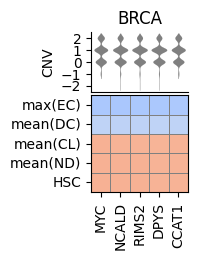

In [16]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming auc_matrix_reordered and Y are already defined
# Example of Y DataFrame with categorical values (-2, -1, 0, 1, 2)
# Calculate figure size dynamically based on the number of columns (heatmap cells width)
n_cols = auc_matrix_reordered.shape[0]
cell_size = 0.25  # size of each cell in inches
fig_width = n_cols * cell_size
fig_height = 3  # adjusted height for the inclusion of violin plot

# Create a violin plot above the heatmap
fig, (ax_violin, ax_heatmap) = plt.subplots(2, 1, figsize=(fig_width, fig_height), 
                                            gridspec_kw={'height_ratios': [1, 4], 'hspace': -0.45})

# Prepare data for violin plot
Y_selected = Y[auc_matrix_reordered.index].melt(var_name='Variable', value_name='CNV')

# Violin plot
sns.violinplot(x='Variable', y='CNV', data=Y_selected, ax=ax_violin, inner=None, linewidth=0.1, color="gray")
ax_violin.set_xticklabels([])
ax_violin.set_xticks([])
ax_violin.set_xlabel('')
# ax_violin.set_ylabel('')
ax_violin.set_title(cancer_type)  # example title, adjust as needed
ax_violin.spines['top'].set_visible(False)
ax_violin.spines['right'].set_visible(False)
ax_violin.spines['left'].set_visible(True)
ax_violin.spines['bottom'].set_visible(True)
ax_violin.set_ylim(-2.5, 2.5)
ax_violin.set_yticks([-2, -1, 0, 1, 2])

# Heatmap
sns.heatmap(auc_matrix_reordered.T, cmap="coolwarm", vmin=-1, vmax=1, cbar=False, 
            linewidths=0.5, linecolor='gray', square=True, xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.5, 'label': 'Scaled AUC'}, ax=ax_heatmap)

for _, spine in ax_heatmap.spines.items():
    spine.set_visible(True)

plt.tight_layout()
plt.show()


d:\conda_evs\label\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\conda_evs\label\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\conda_evs\label\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\conda_evs\label\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping wit

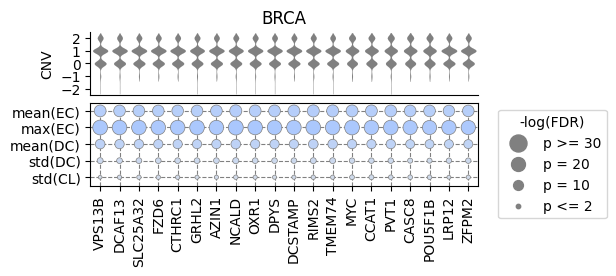

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# assume there is pval_matrix_reordered too

n_cols = auc_matrix_reordered.shape[0]
cell_size = 0.25  # size of each cell in inches
fig_width = n_cols * cell_size
fig_height = 2  # adjusted height for the inclusion of violin plot

# Create a violin plot above the heatmap
fig, (ax_violin, ax_dotplot) = plt.subplots(2, 1, figsize=(fig_width, fig_height), 
                                            gridspec_kw={'height_ratios': [1, 1.3], 'hspace': 0.1})

# Prepare data for violin plot
Y_selected = Y[auc_matrix_reordered.index].melt(var_name='Variable', value_name='CNV')

# Violin plot
sns.violinplot(x='Variable', y='CNV', data=Y_selected, ax=ax_violin, inner=None, linewidth=0.1, color="gray")
ax_violin.set_xticklabels([])
ax_violin.set_xticks([])
ax_violin.set_xlabel('')
# ax_violin.set_ylabel('')
ax_violin.set_title(cancer_type)  # example title, adjust as needed
ax_violin.spines['top'].set_visible(False)
ax_violin.spines['right'].set_visible(False)
ax_violin.spines['left'].set_visible(True)
ax_violin.spines['bottom'].set_visible(True)
ax_violin.set_ylim(-2.5, 2.5)
ax_violin.set_yticks([-2, -1, 0, 1, 2])

# Prepare data for dot plot
auc_values = auc_matrix_reordered.values.flatten()
pval_values = pval_matrix_reordered.values.flatten()
y_labels = np.tile(auc_matrix_reordered.columns, auc_matrix_reordered.shape[0])
x_labels = np.repeat(auc_matrix_reordered.index, auc_matrix_reordered.shape[1])

# Normalize the AUC values for coloring
norm = Normalize(vmin=-1, vmax=1)
cmap = plt.cm.coolwarm
colors = cmap(norm(auc_values))


# Dot plot
dot_data = pd.DataFrame({
    'x': x_labels,
    'y': y_labels,
    'auc': auc_values,
    'pval': pval_values,
})
dot_data['size'] = -np.log10(dot_data['pval'])

# Normalize sizes between a specified range
size_min, size_max = 10, 150  # Example size range
pval_min, pval_max = 2, 30 
dot_data['size'][dot_data['size']>pval_max]=pval_max
sizes = (dot_data['size'] - pval_min) / (pval_max - pval_min) * (size_max - size_min) + size_min


# Plotting the dot plot
scatter = ax_dotplot.scatter(
    x=dot_data['x'], y=dot_data['y'], 
    c=colors, s=sizes,  # Adjust size scaling as needed
    edgecolor='gray', linewidth=0.5
)

# Customizing the dot plot
ax_dotplot.invert_yaxis()
ax_dotplot.set_xticklabels(ax_dotplot.get_xticklabels(), rotation=90)
ax_dotplot.set_xlabel('')
ax_dotplot.set_ylabel('')
ax_dotplot.grid(color='gray', linestyle='dashed')
ax_dotplot.set_axisbelow(True)
ax_dotplot.set_ylim(-0.5, 4.5)
ax_dotplot.set_xlim(-0.5, len(auc_matrix_reordered.index)-.5)


# # Adding legend for color (AUC values)
# cbar = plt.colorbar(scatter, ax=ax_dotplot, aspect=30, pad=0.02)
# cbar.set_label('AUC Values', rotation=270, labelpad=15)

# Adding legend for size (p-values)
size_legend = [
    ax_dotplot.scatter([], [], s=size_max, edgecolor='gray', facecolor='gray', label='p >= 30'),
    ax_dotplot.scatter([], [], s=100, edgecolor='gray', facecolor='gray', label='p = 20'),
    ax_dotplot.scatter([], [], s=50, edgecolor='gray', facecolor='gray', label='p = 10'),
    ax_dotplot.scatter([], [], s=size_min, edgecolor='gray', facecolor='gray', label='p <= 2'),
]
ax_dotplot.legend(handles=size_legend, title='-log(FDR)', loc='upper right', bbox_to_anchor=(1.35, 1))


# plt.yticks([])
# plt.tight_layout()
fig.savefig(r"D:\Manuscripts\pan-mitosis\mitsa\gene\cnv_anova\legend.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)


In [21]:
Y["MYC"]

0      1.0
1      2.0
2      0.0
3      1.0
4      0.0
      ... 
943   -1.0
944    1.0
945    0.0
946    0.0
947    1.0
Name: MYC, Length: 948, dtype: float64

In [31]:
import pandas as pd
import scipy.stats as stats

# Example data
data = {
    'phenotype': X["max(EC)"].to_list(),
    'CNV':       Y["MYC"].to_list()
}
df = pd.DataFrame(data)

# Group data by CNV levels
groups = df.groupby('CNV')['phenotype'].apply(list)

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*groups)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in the phenotype means across CNV levels.")
else:
    print("There is no significant difference in the phenotype means across CNV levels.")


F-statistic: 37.489855406764356
p-value: 6.814670126374128e-23
There is a significant difference in the phenotype means across CNV levels.


In [32]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['phenotype'], groups=df['CNV'], alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  -1.0    0.0   0.0576 0.2504 -0.0225  0.1377  False
  -1.0    1.0  -0.0223 0.8888 -0.1018  0.0572  False
  -1.0    2.0  -0.0802 0.0567 -0.1619  0.0015  False
   0.0    1.0  -0.0799    0.0 -0.1088 -0.0509   True
   0.0    2.0  -0.1378    0.0 -0.1723 -0.1032   True
   1.0    2.0  -0.0579    0.0 -0.0911 -0.0247   True
----------------------------------------------------


In [38]:
tukey.groups

array([ 1.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,
        0.,  0.,  2.,  0.,  1.,  2.,  2.,  0.,  0.,  0.,  1.,  2.,  1.,
        2.,  2.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        2.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
        1.,  0.,  0.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  2.,  0.,
        2.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  2.,  0.,  0.,
        1.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  1.,  1.,  1.,  1.,  1.,
        2.,  2.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,
        1.,  0.,  2.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        2.,  2.,  1.,  1.,  2.,  2.,  0.,  2.,  2.,  2.,  1.,  2

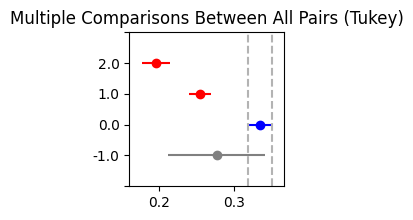

In [40]:
fig = tukey.plot_simultaneous(figsize=(2,2), comparison_name=0.)

In [ ]:
# fix gbm and lgg being one
mit_feats_gbm_lgg = mitosis_feats[mitosis_feats["type"].isin(["LGG"])]

In [ ]:
# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mit_feats_gbm_lgg['bcr_patient_barcode']).intersection(set(gene_expr_all['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats[mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_expr_all[gene_expr_all['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

In [ ]:
gene_expr_all["type"][list(df2_common.index)] = "LGG"

/tmp/ipykernel_3678432/1945969055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expr_all["type"][list(df2_common.index)] = "LGG"


In [ ]:
# Find the common case names between mitosis features and gene expressions
common_cases = pd.Series(list(set(mitosis_feats['bcr_patient_barcode']).intersection(set(gene_expr_all['case_id']))))
## Keep only the rows with the common case names in both dataframes
df1_common = mitosis_feats[mitosis_feats['bcr_patient_barcode'].isin(common_cases)]
df2_common = gene_expr_all[gene_expr_all['case_id'].isin(common_cases)]
df2_common = df2_common.drop_duplicates(subset='case_id')

In [ ]:
df2_common.to_csv("PORPOISE_data_matched.csv", index=None)